# Install dependencies

In [1]:
#Install dependencies
!pip install numpy
!pip install pandas 
!pip install matplotlib 
!pip install tqdm 
!pip install scipy  

You should consider upgrading via the 'c:\users\ibai\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\ibai\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\ibai\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\ibai\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\ibai\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Import dependencies

In [2]:
import numpy as np # Required library to manage data
import pandas as pd # Required library to manage data
from tqdm import tqdm
from scipy import stats as st
import time

# Data

## Clear data

In [3]:
FILE = "dataset.tsp"

#Read the file
with open("raw\\"+FILE) as file:
    lines= file.readlines()

#Variable to dump data into a file
dataset= ""

#Read line by line
for line in lines:
    #The lines starting by digits are data, others are metadata
    able = line[0].isdigit()
    #If the line contains data it is dumped into dataset variable in csv structure
    if able:
        line_array = line.split()
        line= line_array[1] + "," + line_array[2] + "\n"
        dataset += line

CSV_FILE = FILE.split('.')
CSV_FILE = "refined\\"+CSV_FILE[0]+".csv"
#Dump dataset variable data into a file
with open(CSV_FILE, "w") as file:
    file.write(dataset)


## Show map

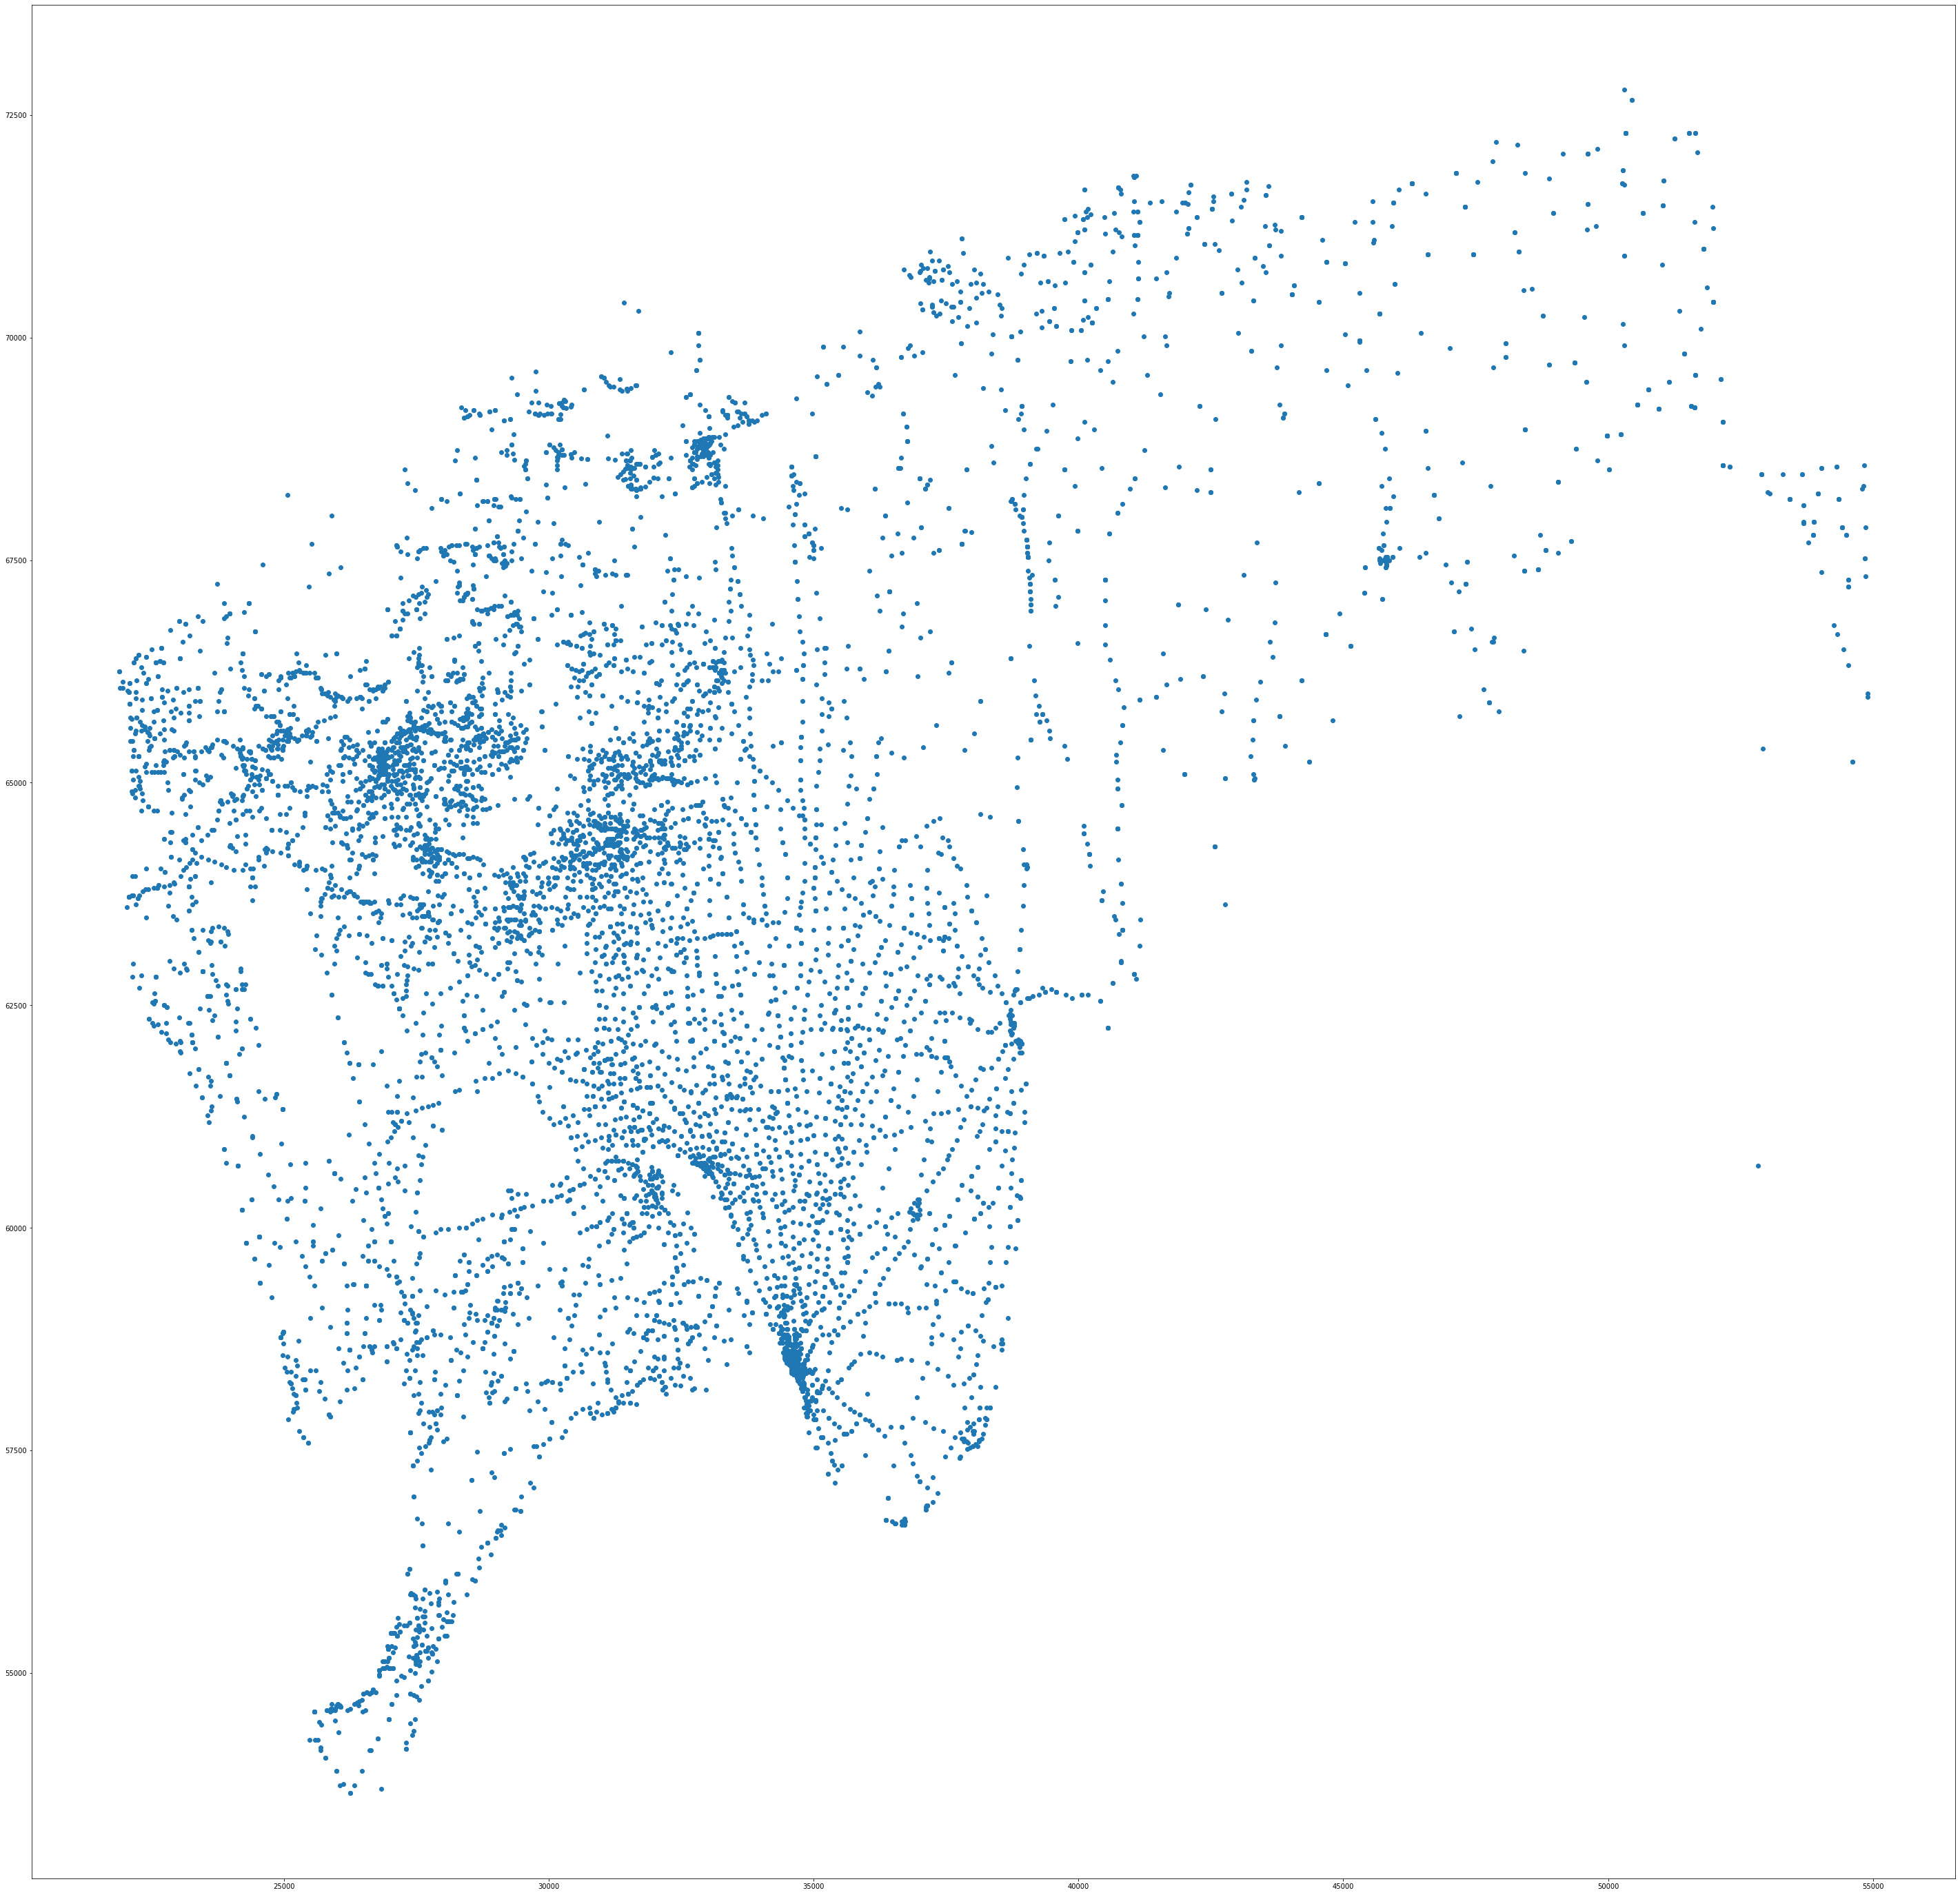

In [4]:
import pandas as pd # Required library to manage data
import matplotlib.pyplot as plt # Required for image generation

df=pd.read_csv(CSV_FILE, sep=',',header=None)

#Generate figure
plt.figure(figsize=(50, 50))
plt.scatter(df[0], df[1])

#Save figure and clear notebook (too big image)
plt.savefig('Initial_map.png')
#plt.clf()

## Remove duplications

In [5]:
import pandas as pd # Required library to manage data

df=pd.read_csv(CSV_FILE, sep=',', header=None)

print("Number of rows: {}".format(len(df)))

print("Duplicated rows: {}".format(df.duplicated().sum()))

# Use keep='first' to keep the first occurrence 
df= df.drop_duplicates(keep='first')

print("Number of rows: {}".format(len(df)))

df.to_csv(CSV_FILE, sep=',', index=False, header=None)

Number of rows: 9152
Duplicated rows: 2429
Number of rows: 6723


## Show map

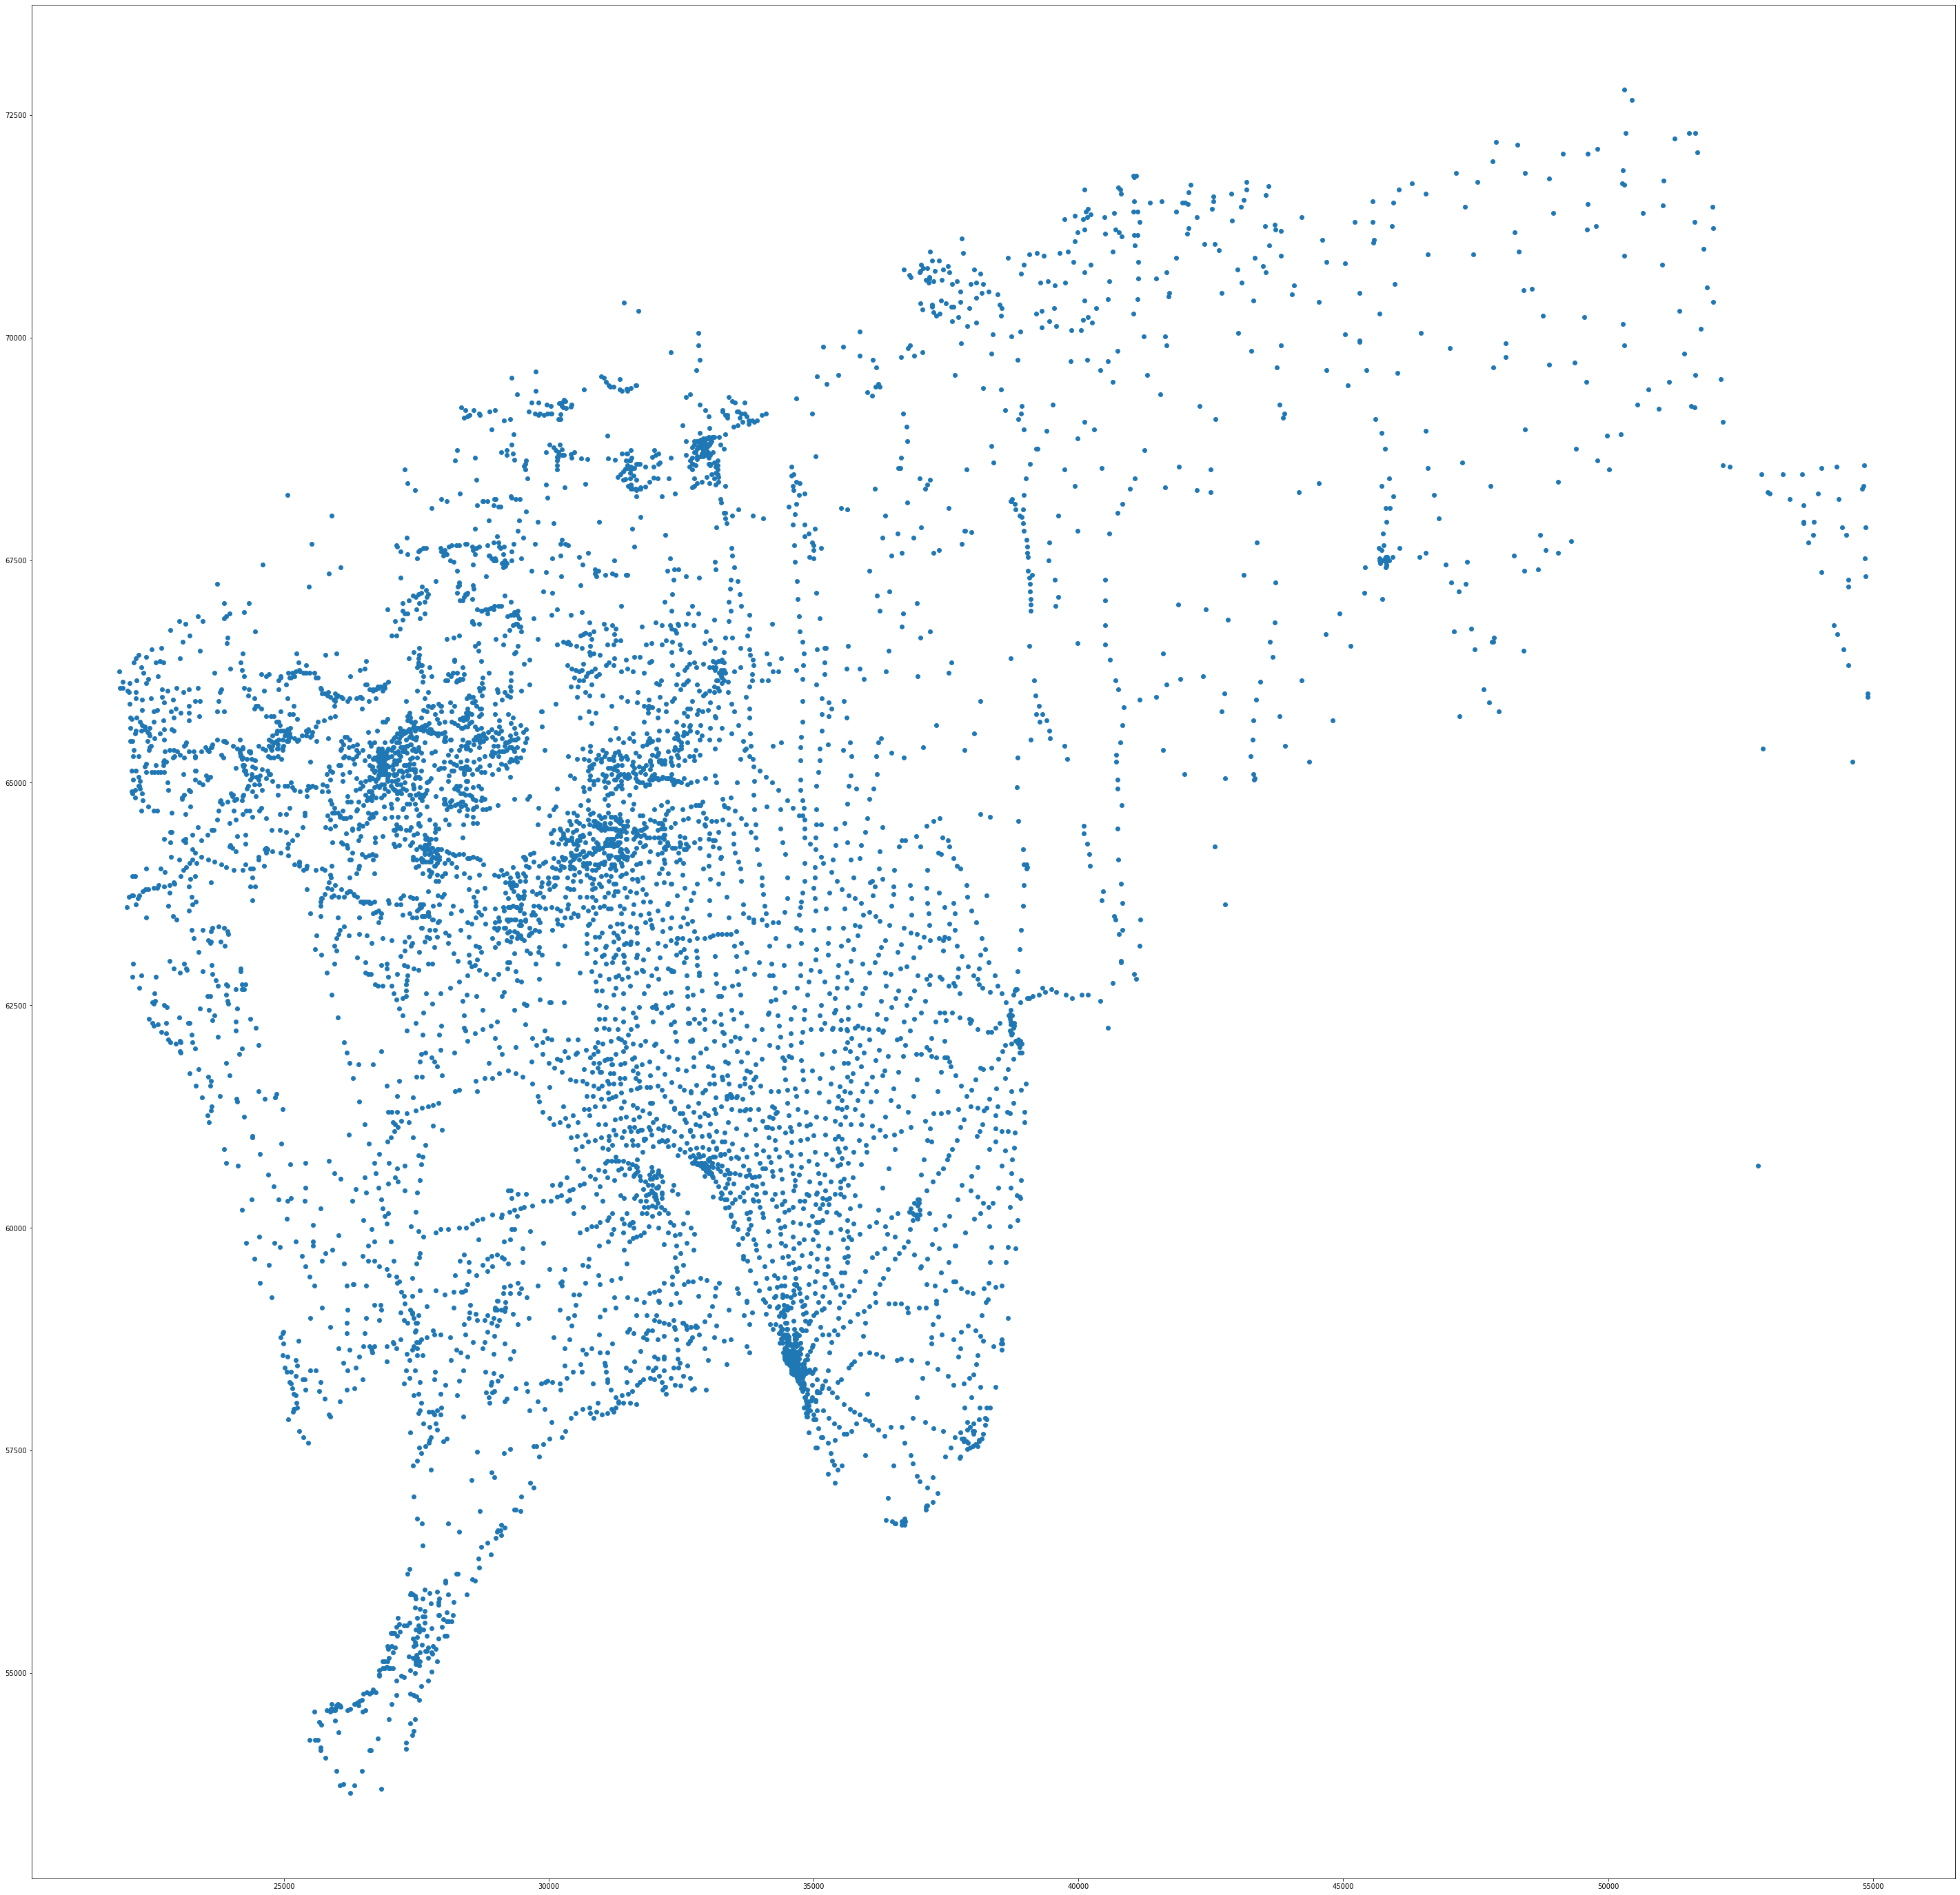

In [6]:
import pandas as pd # Required library to manage data
import matplotlib.pyplot as plt # Required for image generation

df=pd.read_csv(CSV_FILE, sep=',',header=None)

#Generate figure
plt.figure(figsize=(50, 50))
plt.scatter(df[0], df[1])

#Save figure and clear notebook (too big image)
plt.savefig('Reduced_map.png')
#plt.clf()

## Subset of data

In [7]:
import pandas as pd # Required library to manage data

CSV_FILE="refined/dataset.csv"

SUBSET_SIZE = 15
df=pd.read_csv(CSV_FILE, sep=',', header=None)

df= df[:SUBSET_SIZE] #Take the first SUBSET_SIZE elements

print("Number of rows: {}".format(len(df)))

df.to_csv("refined/dataset_reduced.csv", sep=',', index=False, header=None)

Number of rows: 15


## Show map

<Figure size 3600x3600 with 0 Axes>

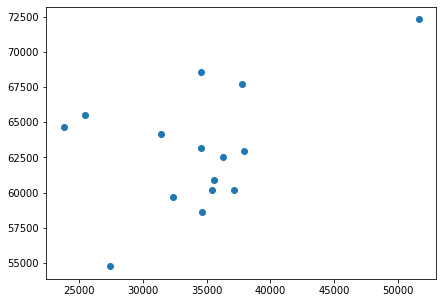

In [8]:
import pandas as pd # Required library to manage data
import matplotlib.pyplot as plt # Required for image generation

CSV_FILE="refined/dataset_reduced.csv"
df=pd.read_csv(CSV_FILE, sep=',',header=None)

#Generate figure
plt.figure(figsize=(50, 50))
plt.scatter(df[0], df[1])
plt.savefig('Subset_mapXL.png')
plt.clf()

plt.figure(figsize=(7, 5))
plt.scatter(df[0], df[1])
plt.savefig('Subset_mapS.png')
#plt.clf()



# Travelling Salesman Problem

## Calculate distances between cities

In [9]:
"""
The main structure of the distance between cities follows the next matrix, 
where column and row represent origin and destination and the value represent 
the distance between these two points.

        city1   city2   city3   ...
city1     0
city2             0
city3                     0
...

"""

'\nThe main structure of the distance between cities follows the next matrix, \nwhere column and row represent origin and destination and the value represent \nthe distance between these two points.\n\n        city1   city2   city3   ...\ncity1     0\ncity2             0\ncity3                     0\n...\n\n'

In [10]:
CSV_FILE="refined\dataset_reduced.csv"

def calc_distance_matrix(cities):
    city_distances= np.array(np.zeros((len(cities), len(cities)))) #Initialize matrix with 0-s
    for column in tqdm(range(len(cities))):
        for row in range(len(cities)):
            a= df.iloc[column]
            b= df.iloc[row]
            city_distances[column][row]= np.linalg.norm((a - b))
    return city_distances


df=pd.read_csv(CSV_FILE, sep=',',header=None)

distances = calc_distance_matrix(df)


df.to_csv("routes.csv", sep=',', index=False, header=None)

np.savetxt("routes.csv", distances, delimiter=",")

100%|██████████| 15/15 [00:00<00:00, 94.94it/s]


## Hyperparameters

In [11]:

BETA = 3 #BETA is a parameter which weighs the relative importance of closeness
K= 50 #K is the number of ants
Q0= 0.3 #Q0 is a constant for defining the probability to take the best road or explore new one according to probability distribution
ALPHA= 0.1
N_MAX_CASES= 4 #When N_MAX_CASES ants converge into the same cost it is considered as a final optimal solution
ITERATIONS = 100

M_K= [] #Memory of visited cities

ROUTES_CSV="routes.csv"
CSV_FILE="refined\dataset_reduced.csv"

cities = pd.read_csv(CSV_FILE, sep=',',header=None)
INITIAL_CITY= cities.iloc[0]
INITIAL_CITY[2]= 0

N_CITIES= len(cities)
T0 = 1/N_CITIES

distances = pd.read_csv(ROUTES_CSV, sep=',',header=None)
heuristics = np.array(np.zeros((N_CITIES, N_CITIES)))

pheromones = np.array(np.zeros((N_CITIES, N_CITIES)))
pheromones_global = np.array(np.zeros((N_CITIES, N_CITIES)))

## Code

### Memory management

In [12]:
def add_to_memory(city):
    global M_K
    M_K.append([ city[0], city[1], city[2] ])
     
def is_in_memory(city):
    global M_K
    if [ city[0], city[1], city[2] ] in M_K:
        return True
    return False
 

### Matrix initializations

In [13]:

def initialize_pheromones():
    global pheromones, pheromones_global
    pheromones_global = np.full((len(pheromones), len(pheromones)), 1/N_CITIES, dtype=float)
    pheromones = pheromones_global

def initialize_heuristics():
    global heuristics
    for column in tqdm(range(len(distances))):
        for row in range(len(distances)):
            if distances[column][row] > 0:
                heuristics[column][row] = 1/distances[column][row] #The heuristic value is the inverse of the distance between two cities
            else: #The heuristic value for same node must be 1 to not perjudicate the calculus of probability
                heuristics[column][row] = 1


### Route performance and utils

In [14]:
def calc_rute_distance():
    def calc_distance(a, b):
        return np.linalg.norm(a-b)
    distance = 0
    for index in range(len(M_K)):
        array= np.array( [[M_K[index][0], M_K[index][1]]] )
        if index == len(M_K)-1:
            distance += calc_distance(array,  np.array( [[M_K[0][0], M_K[0][1]]] ))
            break
        distance += calc_distance(array,  np.array( [[M_K[index+1][0], M_K[index+1][1]]] ))
    return distance

def is_finished():
    if len(M_K) == N_CITIES:
        return True
    return False
    
def get_route():
    matrix= np.matrix(M_K)
    route=[np.squeeze(np.asarray(matrix[:,2])), calc_rute_distance()]
    return route


### Pheromone management

In [15]:
def update_pheromone_local():
    global pheromones 
    pheromones_aux = pheromones 
    pheromones = pheromones *  (1-ALPHA) #Evaporation
    for index in range(len(M_K)):
        origin= int(M_K[index][2])
        if index == len(M_K)-1:
            destination= int(M_K[0][2])
            pheromones[origin][destination]= pheromones_aux[origin][destination] + ALPHA * T0 #Trail
            break
        destination= int(M_K[index+1][2])
        pheromones[origin][destination]= pheromones_aux[origin][destination] + ALPHA * T0 #Trail
        
    
def update_pheromone_global(best_solution, improvement= True):
    global pheromones_global, pheromones
    pheromones_global_aux = pheromones_global
    if improvement:
        pheromones_global = pheromones_global * (1-ALPHA/2)
    else:
        pheromones_global = pheromones_global * (1-ALPHA)
    solution = best_solution[0]
    for index in range(len(solution)):
        delta = best_solution[1]/10000
        origin= int(solution[index])
        if index == len(solution)-1:
            destination= int(solution[0])
            pheromones_global[origin][destination]=  pheromones_global_aux[origin][destination] + ALPHA * 1/(delta)
            break
        destination= int(solution[index+1])
        pheromones_global[origin][destination]= pheromones_global_aux[origin][destination] + ALPHA * 1/(delta)


### Path selection

In [16]:
def calc_probability_p(origin, destination): #P(r, s) -- Probability of each solution
    global pheromones, heuristics, M_K
    if not is_in_memory(destination):
        origin = int(origin[2]) # Get origin city index 
        destination = int(destination[2]) # Get destination city index 
        top=  pow(heuristics[origin, destination], BETA) * pheromones[origin, destination] # Calculate paper formula topside
        down = 0
        for element in M_K:#For every element in the memory
            down+= pow(heuristics[origin][int(element[2])], BETA) * pheromones[origin][int(element[2])] # Calculate paper formula downside
        return top/down
    return 0


def calc_probability_s(origin, destination): #s -- Best solution
    global pheromones, heuristics, M_K
    if not is_in_memory(destination):
        origin = int(origin[2]) # Get origin city index 
        destination = int(destination[2]) # Get destination city index 
        s=  pow( heuristics[origin, destination], BETA) * pheromones[origin, destination]
        return s
    return 0

    
def search_next_city(origin):
    global N_CITIES, cities 
    candidates = []
    while True:
        if np.random.random(1)[0] <= Q0:
            for option in range(N_CITIES): #The last city has been calculated among others, so its not necesary to calculate
                destination= cities.iloc[option] #Get city coordinates
                destination[2]= option #Set city index
                destination[3]= calc_probability_s(origin, destination) #Set city probability
                candidates.append(destination) #Save the posible destination
            
            
            matrix= np.matrix(candidates) #Convert 2D array to numpy
            probabilities = np.squeeze(np.asarray(matrix[:,3])) #Extract probability of each candidate and convert to array
            choice = np.max(probabilities) #Selected city with highest probability
            where= np.where(probabilities == choice)[0][0] #Find which row corresponds to the city
            destination = np.squeeze(np.asarray(matrix[where])) #Get the destination point
            if not is_in_memory(destination): return destination #Return the city
        else:      
            for option in range(N_CITIES): #The last city has been calculated among others, so its not necesary to calculate
                destination= cities.iloc[option] #Get city coordinates
                destination[2]= option #Set city index
                destination[3]= calc_probability_p(origin, destination) #Set city probability
                candidates.append(destination) #Save the posible destination
            
            matrix= np.matrix(candidates) #Convert 2D array to numpy
            probabilities = np.squeeze(np.asarray(matrix[:,3])) #Extract probability of each candidate and convert to array
            cityindexes= np.squeeze(np.asarray(matrix[:,2])) #Extract index of each candidate and convert to array
            probabilities /= probabilities.sum() #Normalizze the probability distribution
            choice = np.random.choice(cityindexes, p=probabilities) #Selected city with the probability distribution
            where= np.where(cityindexes == choice)[0][0] #Find which row corresponds to the city
            destination = np.squeeze(np.asarray(matrix[where])) #Get the destination point
            if not is_in_memory(destination): return destination #Return the city


### Extensions

In [17]:
def incrementQ0(): #Increment progressively Q0 until 0,9
    global Q0, ITERATIONS
    limit = 0.9
    if Q0 < limit:
        Q0 += (limit - Q0)/(ITERATIONS)
        
def decrementBETA(): #Decrement progressively Beta until 1
    global BETA, K
    limit = 1
    if BETA < limit:
        BETA -= abs((limit - 3)/(K/2))

### Algorithm

### Experiments

In [18]:
#Experiments
# experiment parameter is used to append to arrays in the correct index
def experiment_ALL(experiment):
    global Q0, pheromones, pheromones_global, ants_conduct, colony_conduct
    initialize_pheromones()
    initialize_heuristics()
    buffer = []
    for ant in tqdm(range(K)):
        pheromones = pheromones_global
        Q0= 0.3
        with open('report_ALL.txt', 'a') as file:
            file.write('Ant '+ str(ant)+"\n")
        best_solution = []
        ants_conduct[experiment].append([])
        for iteration in range(ITERATIONS):
            add_to_memory(INITIAL_CITY)
            next_city= search_next_city(INITIAL_CITY)
            add_to_memory(next_city)
            while not is_finished():
                next_city= search_next_city(next_city)
                add_to_memory(next_city)
            update_pheromone_local()
            solution= get_route()
            if not best_solution or best_solution[1] > solution[1]:
                best_solution= solution
            incrementQ0()
            ants_conduct[experiment][ant].append(solution[1])
            del M_K[:]

        colony_conduct[experiment].append(best_solution[1])

        with open('report_ALL.txt', 'a') as file:
            msg = "Route order: " + str(best_solution[0]) + "  --  Cost: " + str(best_solution[1]) +"\n"
            file.write(msg)
            
        buffer.append(best_solution[1]) 
            
        if len(buffer) >= N_MAX_CASES and np.max(buffer[-N_MAX_CASES:]) == np.min(buffer[-N_MAX_CASES:]): break
        
        update_pheromone_global(best_solution)
        decrementBETA()

def experiment_NO_DECREMENT_BETA (experiment):
    global Q0, pheromones, pheromones_global, ants_conduct, colony_conduct
    initialize_pheromones()
    initialize_heuristics()
    buffer = []
    for ant in tqdm(range(K)):
        pheromones = pheromones_global
        Q0= 0.3
        with open('report_NO_DECREMENT_BETA.txt', 'a') as file:
            file.write('Ant '+ str(ant)+"\n")
        best_solution = []
        ants_conduct[experiment].append([])
        for iteration in range(ITERATIONS):
            add_to_memory(INITIAL_CITY)
            next_city= search_next_city(INITIAL_CITY)
            add_to_memory(next_city)
            while not is_finished():
                next_city= search_next_city(next_city)
                add_to_memory(next_city)
            update_pheromone_local()
            solution= get_route()
            if not best_solution or best_solution[1] > solution[1]:
                best_solution= solution
            incrementQ0()
            ants_conduct[experiment][ant].append(solution[1])
            del M_K[:]

        colony_conduct[experiment].append(best_solution[1])

        with open('report_NO_DECREMENT_BETA.txt', 'a') as file:
            msg = "Route order: " + str(best_solution[0]) + "  --  Cost: " + str(best_solution[1]) +"\n"
            file.write(msg)
            
        buffer.append(best_solution[1]) 
            
        if len(buffer) >= N_MAX_CASES and np.max(buffer[-N_MAX_CASES:]) == np.min(buffer[-N_MAX_CASES:]): break
        
        update_pheromone_global(best_solution)

def experiment_NO_INCREMENT_Q(experiment):
    global Q0, pheromones, pheromones_global, ants_conduct, colony_conduct
    initialize_pheromones()
    initialize_heuristics()
    buffer = []
    for ant in tqdm(range(K)):
        pheromones = pheromones_global
        Q0= 0.9
        with open('report_NO_INCREMENT_Q.txt', 'a') as file:
            file.write('Ant '+ str(ant)+"\n")
        best_solution = []
        ants_conduct[experiment].append([])
        for iteration in range(ITERATIONS):
            add_to_memory(INITIAL_CITY)
            next_city= search_next_city(INITIAL_CITY)
            add_to_memory(next_city)
            while not is_finished():
                next_city= search_next_city(next_city)
                add_to_memory(next_city)
            update_pheromone_local()
            solution= get_route()
            if not best_solution or best_solution[1] > solution[1]:
                best_solution= solution
            #incrementQ0()
            ants_conduct[experiment][ant].append(solution[1])
            del M_K[:]

        colony_conduct[experiment].append(best_solution[1])

        with open('report_NO_INCREMENT_Q.txt', 'a') as file:
            msg = "Route order: " + str(best_solution[0]) + "  --  Cost: " + str(best_solution[1]) +"\n"
            file.write(msg)
            
        buffer.append(best_solution[1]) 
            
        if len(buffer) >= N_MAX_CASES and np.max(buffer[-N_MAX_CASES:]) == np.min(buffer[-N_MAX_CASES:]): break
        
        update_pheromone_global(best_solution)
        decrementBETA()

def experiment_NO_DIVIDE_ALPHA(experiment):
    global Q0, pheromones, pheromones_global, ants_conduct, colony_conduct
    initialize_pheromones()
    initialize_heuristics()
    buffer = []
    for ant in tqdm(range(K)):
        pheromones = pheromones_global
        Q0= 0.3
        with open('report_NO_DIVIDE_ALPHA.txt', 'a') as file:
            file.write('Ant '+ str(ant)+"\n")
        best_solution = []
        ants_conduct[experiment].append([])
        for iteration in range(ITERATIONS):
            add_to_memory(INITIAL_CITY)
            next_city= search_next_city(INITIAL_CITY)
            add_to_memory(next_city)
            while not is_finished():
                next_city= search_next_city(next_city)
                add_to_memory(next_city)
            update_pheromone_local()
            solution= get_route()
            if not best_solution or best_solution[1] > solution[1]:
                best_solution= solution
            incrementQ0()
            ants_conduct[experiment][ant].append(solution[1])
            del M_K[:]

        colony_conduct[experiment].append(best_solution[1])

        with open('report_NO_DIVIDE_ALPHA.txt', 'a') as file:
            msg = "Route order: " + str(best_solution[0]) + "  --  Cost: " + str(best_solution[1]) +"\n"
            file.write(msg)
            
        buffer.append(best_solution[1]) 
            
        if len(buffer) >= N_MAX_CASES and np.max(buffer[-N_MAX_CASES:]) == np.min(buffer[-N_MAX_CASES:]): break
        
        update_pheromone_global(best_solution, improvement=False)
        decrementBETA()

def experiment_NO_INCREMENT_Q_NO_DECREMENT_BETA(experiment):
    global Q0, pheromones, pheromones_global, ants_conduct, colony_conduct
    initialize_pheromones()
    initialize_heuristics()
    buffer = []
    for ant in tqdm(range(K)):
        pheromones = pheromones_global
        Q0= 0.9
        with open('report_NO_INCREMENT_Q_NO_DECREMENT_BETA.txt', 'a') as file:
            file.write('Ant '+ str(ant)+"\n")
        best_solution = []
        ants_conduct[experiment].append([])
        for iteration in range(ITERATIONS):
            add_to_memory(INITIAL_CITY)
            next_city= search_next_city(INITIAL_CITY)
            add_to_memory(next_city)
            while not is_finished():
                next_city= search_next_city(next_city)
                add_to_memory(next_city)
            update_pheromone_local()
            solution= get_route()
            if not best_solution or best_solution[1] > solution[1]:
                best_solution= solution
            #incrementQ0()
            ants_conduct[experiment][ant].append(solution[1])
            del M_K[:]

        colony_conduct[experiment].append(best_solution[1])

        with open('report_NO_INCREMENT_Q_NO_DECREMENT_BETA.txt', 'a') as file:
            msg = "Route order: " + str(best_solution[0]) + "  --  Cost: " + str(best_solution[1]) +"\n"
            file.write(msg)
            
        buffer.append(best_solution[1]) 
            
        if len(buffer) >= N_MAX_CASES and np.max(buffer[-N_MAX_CASES:]) == np.min(buffer[-N_MAX_CASES:]): break
        
        update_pheromone_global(best_solution)

def experiment_NO_DECREMENT_BETA_NO_DIVIDE_ALPHA (experiment):
    global Q0, pheromones, pheromones_global, ants_conduct, colony_conduct
    initialize_pheromones()
    initialize_heuristics()
    buffer = []
    for ant in tqdm(range(K)):
        pheromones = pheromones_global
        Q0= 0.3
        with open('report_NO_DECREMENT_BETA_NO_DIVIDE_ALPHA.txt', 'a') as file:
            file.write('Ant '+ str(ant)+"\n")
        best_solution = []
        ants_conduct[experiment].append([])
        for iteration in range(ITERATIONS):
            add_to_memory(INITIAL_CITY)
            next_city= search_next_city(INITIAL_CITY)
            add_to_memory(next_city)
            while not is_finished():
                next_city= search_next_city(next_city)
                add_to_memory(next_city)
            update_pheromone_local()
            solution= get_route()
            if not best_solution or best_solution[1] > solution[1]:
                best_solution= solution
            incrementQ0()
            ants_conduct[experiment][ant].append(solution[1])
            del M_K[:]

        colony_conduct[experiment].append(best_solution[1])

        with open('report_NO_DECREMENT_BETA_NO_DIVIDE_ALPHA.txt', 'a') as file:
            msg = "Route order: " + str(best_solution[0]) + "  --  Cost: " + str(best_solution[1]) +"\n"
            file.write(msg)
            
        buffer.append(best_solution[1]) 
            
        if len(buffer) >= N_MAX_CASES and np.max(buffer[-N_MAX_CASES:]) == np.min(buffer[-N_MAX_CASES:]): break
        
        update_pheromone_global(best_solution, improvement=False)

def experiment_NO_INCREMENT_Q_NO_DIVIDE_ALPHA(experiment):
    global Q0, pheromones, pheromones_global, ants_conduct, colony_conduct
    initialize_pheromones()
    initialize_heuristics()
    buffer = []
    for ant in tqdm(range(K)):
        pheromones = pheromones_global
        Q0= 0.9
        with open('report_NO_INCREMENT_Q_NO_DIVIDE_ALPHA.txt', 'a') as file:
            file.write('Ant '+ str(ant)+"\n")
        best_solution = []
        ants_conduct[experiment].append([])
        for iteration in range(ITERATIONS):
            add_to_memory(INITIAL_CITY)
            next_city= search_next_city(INITIAL_CITY)
            add_to_memory(next_city)
            while not is_finished():
                next_city= search_next_city(next_city)
                add_to_memory(next_city)
            update_pheromone_local()
            solution= get_route()
            if not best_solution or best_solution[1] > solution[1]:
                best_solution= solution
            #incrementQ0()
            ants_conduct[experiment][ant].append(solution[1])
            del M_K[:]

        colony_conduct[experiment].append(best_solution[1])

        with open('report_NO_INCREMENT_Q_NO_DIVIDE_ALPHA.txt', 'a') as file:
            msg = "Route order: " + str(best_solution[0]) + "  --  Cost: " + str(best_solution[1]) +"\n"
            file.write(msg)
            
        buffer.append(best_solution[1]) 
            
        if len(buffer) >= N_MAX_CASES and np.max(buffer[-N_MAX_CASES:]) == np.min(buffer[-N_MAX_CASES:]): break
        
        update_pheromone_global(best_solution, improvement=False)
        decrementBETA()

def experiment_NO_INCREMENT_Q_NO_DECREMENT_BETA_NO_DIVIDE_ALPHA(experiment):
    global Q0, pheromones, pheromones_global, ants_conduct, colony_conduct
    initialize_pheromones()
    initialize_heuristics()
    buffer = []
    for ant in tqdm(range(K)):
        pheromones = pheromones_global
        Q0= 0.9
        with open('report_NO_INCREMENT_Q_NO_DECREMENT_BETA_NO_DIVIDE_ALPHA.txt', 'a') as file:
            file.write('Ant '+ str(ant)+"\n")
        best_solution = []
        ants_conduct[experiment].append([])
        for iteration in range(ITERATIONS):
            add_to_memory(INITIAL_CITY)
            next_city= search_next_city(INITIAL_CITY)
            add_to_memory(next_city)
            while not is_finished():
                next_city= search_next_city(next_city)
                add_to_memory(next_city)
            update_pheromone_local()
            solution= get_route()
            if not best_solution or best_solution[1] > solution[1]:
                best_solution= solution
            #incrementQ0()
            ants_conduct[experiment][ant].append(solution[1])
            del M_K[:]

        colony_conduct[experiment].append(best_solution[1])

        with open('report_NO_INCREMENT_Q_NO_DECREMENT_BETA_NO_DIVIDE_ALPHA.txt', 'a') as file:
            msg = "Route order: " + str(best_solution[0]) + "  --  Cost: " + str(best_solution[1]) +"\n"
            file.write(msg)
            
        buffer.append(best_solution[1]) 
            
        if len(buffer) >= N_MAX_CASES and np.max(buffer[-N_MAX_CASES:]) == np.min(buffer[-N_MAX_CASES:]): break
        
        update_pheromone_global(best_solution, improvement=False)

def save_stats(_n_experiments, _colony_conduct, _ants_conduct, filename= 'stats.txt'): 
    for exp in range(_n_experiments):
        subject = _colony_conduct[exp]
        mean= np.mean(subject)
        median= np.median(subject)
        mode= st.mode(subject)[0][0]
        std= np.std(subject)

        with open(filename, 'a') as file:
            stat= "###################\n"
            stat+= "Ant Colony {}\n".format(exp)
            stat+= "Mean: {0:.2f}\t Median: {1:.2f}\t Mode: {2:.2f}\t Standard deviation: {3:.2f}\n".format(mean, median, mode, std)
            file.write(stat)
            
        for ant in range(len(_ants_conduct[exp])):
            subject = _ants_conduct[exp][ant]
            mean= np.mean(subject)
            median= np.median(subject)
            mode= st.mode(subject)[0][0]
            std= np.std(subject)
            with open(filename, 'a') as file:
                stat= "-- Ant {0:.0f}\t Mean: {1:.2f}\t Median: {2:.2f}\t Mode: {3:.2f}\t Standard deviation: {4:.2f}\n".format(ant, mean, median, mode, std)
                file.write(stat)


In [19]:
experiments= [experiment_ALL, experiment_NO_DECREMENT_BETA, experiment_NO_INCREMENT_Q, experiment_NO_DIVIDE_ALPHA, 
              experiment_NO_INCREMENT_Q_NO_DECREMENT_BETA, experiment_NO_DECREMENT_BETA_NO_DIVIDE_ALPHA, 
              experiment_NO_INCREMENT_Q_NO_DIVIDE_ALPHA, experiment_NO_INCREMENT_Q_NO_DECREMENT_BETA_NO_DIVIDE_ALPHA]
      

n_experiments= 10

for experiment in experiments:
    start_time = time.time()
    ants_conduct= []
    colony_conduct=[]

    for rep in range(n_experiments):
        ants_conduct.append([])
        colony_conduct.append([])
        experiment(experiment=rep)

    filename= "stats_{}.txt".format(experiment.__name__)
    
    #General stats
    subject = colony_conduct
    aux = []
    for exp in subject:
        for ant in exp: 
            aux.append(ant)
    mean= np.mean(aux)
    median= np.median(aux)
    mode= st.mode(aux)[0][0]
    std= np.std(aux)
    ###
    with open(filename, 'a') as file:
        msg= "Mean: {0:.2f}\t Median: {1:.2f}\t Mode: {2:.2f}\t Standard deviation: {3:.2f}\n".format(mean, median, mode, std)
        msg+= "Time: {0:.2f} seconds\n".format(time.time() - start_time)
        file.write(msg)
        
    save_stats(n_experiments, colony_conduct, ants_conduct, filename)
    del ants_conduct
    del colony_conduct
   
        



  0%|          | 0/50 [00:09<?, ?it/s]


KeyboardInterrupt: 

# Draw route in map

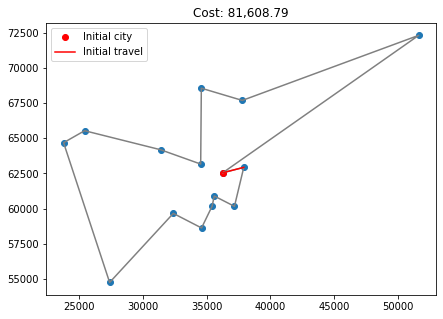

In [ ]:
import pandas as pd # Required library to manage data
import matplotlib.pyplot as plt # Required for image generation

CSV_FILE="refined/dataset_reduced.csv"
dfd=pd.read_csv(CSV_FILE, sep=',',header=None)

route= [ 0, 12, 13, 14,  4,  1,  9,  6,  8, 10, 11,  7,  5,  3,  2]


plt.figure(figsize=(7, 5))
plt.scatter(dfd[0], dfd[1])

x_values =[]
y_values= []
for index in range(len(route)):
    if index < len(route)-1:
        x_values.append(dfd[0][route[index]])
        y_values.append(dfd[1][route[index]])
        x_values.append(dfd[0][route[index+1]])
        y_values.append(dfd[1][route[index+1]])
    else:
        x_values.append(dfd[0][route[index]])
        y_values.append(dfd[1][route[index]])
        x_values.append(dfd[0][route[0]])
        y_values.append(dfd[1][route[0]])
        
    #plt.plot(x_values, y_values, label=index)
    
plt.plot(x_values, y_values, color="gray")

#Remarking initial city and initial travel
plt.scatter(dfd[0][route[0]], dfd[1][route[0]], color="red", label="Initial city")
plt.plot([dfd[0][route[0]], dfd[0][route[1]]],[dfd[1][route[0]], dfd[1][route[1]]], color="red", label="Initial travel")


plt.title("Cost: 81,608.79")
plt.legend()
plt.savefig('routes/all_mode.png')
#plt.clf()
